<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialMLTF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working paper: https://arxiv.org/abs/2005.02347 
GitHub: https://github.com/differential-machine-learning

# Differential Deep Learning

---
Updated for TensorFlow 2
---

---
Antoine Savine, January 2021
---

This notebook implements the novel ideas of *twin networks* and *differential training* from the working paper [Differential Machine Learning](https://arxiv.org/abs/2005.02347) by Brian Huge and [Antoine Savine](https://antoinesavine.com) (2020), and applies them in a few simple contexts, including the reproduction of some results from the paper. In the article, we presented the ideas and discussed the algorithms, but skipped important implementation details best covered in a notebook with code. Those details are dicussed here.    

Although this is a *demonstration* notebook, the algorithms are implemented in self contained, modular and extensible blocks of code. They may be easily extracted, extended and integrated into production systems. Some advanced extensions particularly important in a production context are discussed in the [appendices](https://github.com/differential-machine-learning/appendices/).

The code is based on TensorFlow 1.x. You may run the notebook in a local TensorFlow 1.x enviroment *with GPU support*, also with common libraries like numpy and matplotlib. On Google Colab, the correct version of TensorFlow is automatically selected, and all the necessary libraries are preinstalled. All you need is *enable GPU support*: menu runtime/change runtime type and select hardware accelerator GPU.

We do not further discuss the algorithms covered in the article or fundamentals of TensorFlow (see classic resources like [Geron's textbook](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291), first edition for TensorFlow 1.x). For modern deep learning and best practices, we refer e.g. to [Goodfellow and al's Deep Learning Book](https://www.deeplearningbook.org/) or [Andrew Ng's deep learning lectures](https://www.coursera.org/specializations/deep-learning). 

This notebook was ported on TensorFlow 2 in January 2021. The original TensorFlow 1 notebook will no longer be updated.

# Imports

In [2]:
try:
    %matplotlib notebook
except Exception:
    pass

# import and test
import tensorflow as tf2
print("TF version =", tf2.__version__)

# we want TF 2.x
assert tf2.__version__ >= "2.0"

# disable eager execution etc
tf = tf2.compat.v1
tf.disable_eager_execution()

# disable annoying warnings
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')

# make sure we have GPU support
print("GPU support = ", tf.test.is_gpu_available())

# import other useful libs
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

TF version = 2.4.1
GPU support =  False


# Part I : Core Functions

## Feedforward neural network in TensorFlow

This function builds a classic feedforward neural network in TensorFlow, implementing the set of equations $(3)$ from the article. This is classic deep learning code and a direct translation of equations $(3)$ in Python. We tried to keep notations consistent with the paper.

The weights are initialized with TensorFlow's  [variance_scaling_initializer](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/initializers/variance_scaling), implementing the particularly effective [Xavier/Glorot](https://www.deeplearning.ai/ai-notes/initialization/)  initialization strategy, a best practice in modern deep learning. A correct initialization is a key ingredient in an effective practical implementation of deep learning. 

Since the network is initialized randomly, we also implement seed in the interest of reproducibility.

In [3]:
def vanilla_net(
    input_dim,      # dimension of inputs, e.g. 10
    hidden_units,   # units in hidden layers, assumed constant, e.g. 20
    hidden_layers,  # number of hidden layers, e.g. 4
    seed):          # seed for initialization or None for random
    
    # set seed
    tf.set_random_seed(seed)
    
    # input layer
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
    
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # eq.3, l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # eq. 3, l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # eq. 3, l=2..L-1

    # output layer (index hidden_layers+1)
    ws.append(tf.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # eq. 3, l=L
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

## Explicit backpropagation and twin network

These functions construct the twin network by explicit backpropagation (eq. $(4)$ in the article). The twin network simultaneously and efficiently predicts values and their differentials to inputs, allowing to train on datasets augmented with differential labels (i.e. gradients of labels to inputs, as explained in the working paper). 

In [4]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(
    weights_and_biases, # 2nd output from vanilla_net() 
    zs):                # 3rd output from vanilla_net()
    
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, eq. 4, l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # eq. 4
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # eq. 4
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    

# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

## Vanilla training loop

These are classic training loops for the feedforward neural network. As customary in modern deep learning, the training set is traversed in mini-batches, where the cost function is minimized with the best practice [ADAM](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/AdamOptimizer) algorithm. Andrew Ng's deeplearning.ai web site has an [intuitive presentation of various optimization algorithms in deep learning](https://www.deeplearning.ai/ai-notes/optimization/).

In [5]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    
    m, n = x_train.shape
    
    # minimization loop over mini-batches
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

## Differential training loop

The apparently similar *differential* training loop implements the main idea from the paper, to train twin networks on datasets augmented with differentials of labels to inputs, by minimization of a combined cost function reflecting errors in both predicted values *and predicted derivatives*:

$$
    c = \alpha c_{\text{val}} + \beta c_{\text{diff}}
$$

where $c_{\text{val}}$ is the classic mean square error (MSE) of predictions to labels and $c_{\text{diff}}$ is the cost of wrong derivatives:

$$
    c_{\text{diff}} = \frac{\sum_{\text{inputs j}} \lambda_j^2 {mse}_j}{\text{num inputs}}
$$

where ${mse}_j$ is the mean squared error of derivatives to input $j$ and the weights $\lambda_j$ normalize derivatives so all the components of the cost have similar magnitudes, as explained in the article. We provide a basic normalization formula for the weights a few cells below, and a complete review of data preparation and weighting in [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App2-Preprocessing.pdf).




In [6]:
def diff_training_graph(
    # same as vanilla
    input_dim, 
    hidden_units, 
    hidden_layers, 
    seed, 
    # balance relative weight of values and differentials 
    # loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j) 
    # see online appendix
    alpha, 
    beta,
    lambda_j):
    
    # net, now a twin
    inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.placeholder(real_type)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)

def diff_train_one_epoch(inputs, labels, derivs_labels, 
                         # graph
                         lr_placeholder, minimizer,             
                         # training set, extended
                         x_train, y_train, dydx_train,          
                         # params
                         learning_rate, batch_size, session):   
    
    m, n = x_train.shape
    
    # minimization loop, now with Greeks
    first = 0
    last = min(batch_size, m)
    while first < m:
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        first = last
        last = min(first + batch_size, m)

## Combined outer training loop

The outer training loop optimizes the weights of neural approximators for a number of epochs (complete sweeps of the training set). We applied the recent [one-cycle learning rate schedule](https://arxiv.org/abs/1803.09820) of Leslie Smith and found that it considerably accelerates and stabilizes the training of neural networks. 100 epochs is more than sufficient in most practical cases. A convergence and/or cross-validation test may be included for early stopping. Typical training takes around a second on a decent GPU (longer on Colab's shared GPUs). The approximator class, defined next, holds all the necessary data and parameters, along with the TensorFlow graph and computing session.

In [7]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
    # batching
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)        


## Data normalization

The practical performance of neural networks strongly depends on implementation details, like weight initialization and optimization. Another crucial practicality is the *normalization of training data*. We refer to deep learning texbooks for a discussion of the importance of normalization. One reason is that we need hyperparameters like the learning rate schedule to remain constant over datasets. If notional was to be increased by factor 1M all things equal, gradients would be multiplied by 1M too and learning rates would have to be divided by 1M to keep things similar. Normalizing data avoids manual tinkering of hyperparameters for different datasets. All the examples in the paper: the Gaussian basket, the autocallable trade and the netting set, were all approximated with the exact same hyperparameters. This is only possible with normalized datasets. 

We implement below a *basic* normalization strategy, where the training inputs and labels are normalized by mean and standard deviation, with differentials normalized accordingly. The differential weights in the cost function $\lambda_j$ divide costs by the norm of the normalized differentials, keeping similar the magnitude of all the components of the cost.

We can do a lot better, especially with differential labels. We could perform successive changes of basis, combined with filtering strategies, to feed neural networks with data orthonormal in terms of inputs *and* in terms of differentials, highlighting the most significant risk factors and filtering out the irrelevant ones. This is covered in detail in the [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App2-Preprocessing.pdf), where we discuss novel, and extremely effective data preparation algorithms, exploiting information contained in differential labels to considerably alleviate the load of training neural networks and subsequently, improve training performance and reduce sensitivity to hyperparameters. 

Although the basic normalization implemented here is sufficient for textbook examples, a reliable implementation in production for arbitrary schedules of cash-flows, resilient to very high dimensionality, necessitatesthe more complete data preparation.

Note that the prediction of values and derivatives must be adjusted accordingly: prediction inputs must be normalized, and resulting predictions must be 'un-normalized'. 

In [8]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

## Putting it all together

For convenience, we put it all together in a *Neural_Approximator* class. Most of the code should be self explanatory. 

Note that we compute the coefficients $\alpha$ and $\beta$ for balancing cost between values and derivatives in a straightforward manner:

$$
    \alpha = \frac{1}{1 + \lambda n} \text{ and }  \beta = \frac{\lambda n}{1 + \lambda n}
$$

where $n$ is the number of inputs, so an error on a derivative has a weight similar to a value error, and $\lambda$ is a hyperparameter without significant effect, as explained in the paper, and left to 1, safe for debugging.

We implement a simple, feedforward architecture with 4 hidden layers of 20 units, throughout our tests. We kept the same architecture in production, with the addition of a *wide and deep* layer, inspired by [Google](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html) and discussed in the [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App4-UnsupervisedTraining.pdf).

In [9]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
        self.session = None
                        
    def __del__(self):
        if self.session is not None:
            self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
        if self.session is not None:
            self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

# Part II : Learning Pricing and Risk Functions from LSM samples

As explained in the article, to learn pricing approximations from ground truth labels is not viable for financial applications like regulations or scenario-based risk reports, because the ground truth prices of complex transactions and trading books must be computed with numerical methods like nested Monte-Carlo simulations, where the computation load makes it impossible to simulate training sets in realistic time.

Instead, we **learn from samples** *a la* Lonstaff-Schwartz (or **LSM**, from Valuing American Options by Simulation: A Simple Least-Squares Approach, The Review of Financial Studies, 2001). Our inputs are simulated Markov states at some time $T_1$ (called *exposure date* in the context of regulations), labels are *payoffs* (sum of discounted cash-flows paid after $T_1$) picked on the same Monte-Carlo path, and differential labels are **pathwise derivatives** usually computed with automatic adjoint differentiation (AAD, see [textbook](https://amazon.com/Modern-Computational-Finance-Parallel-Simulations-dp-1119539455/dp/1119539455)) (although in the simple cases of Black & Scholes and Bachelier, we easily compute them explicitly).

It follows that training sets are produced quickly, for a computation cost similar to *one* Monte-Carlo price, but we now expect the machine to learn pricing and risk functions without having ever seen a price or a delta, only samples. That training still converges to the correct pricing and risk function may be seen somewhat magical. Fortunately, Longstaff & Schwartz' idea of training on samples is backed by solid mathematics and guaranteed to converge to the true pricing function. A sketch of proof is provided [here](https://github.com/differential-machine-learning/appendices/blob/master/App1-LSM.pdf).

## Black & Scholes

As a first, and somewhat compulsory example, we learn the pricing and risk function of a European call in Black & Scholes' classic model of 1973, training on simulated LSM samples and verifying performance against the correct pricing function, given by Black & Scholes formula.

The simple code below generates a training set of LSM samples, along with pathwise differentials, and a test set of true prices and risks computed in closed form.

The implementation is a fast, vectorized Monte-Carlo simulation in numpy. Code should be self explanatory, safe for two maybe unusual features. We allow raising volatility by a factor *volMult* between now (time $0$) and the pricing date $T_1$ to get more samples on the wings and better learn asymptotics. Our labels may also represent *the average of two antithetic samples* instead of one, which reduces variance for an acceptable cost in this simple case. 

Pathwise differentials are easily computed in Black & Scholes, where:

$$
    S_{T_2} = S_{T_1} exp \left[ - \frac{\sigma^2}{2} \left( {T_2} - {T_1} \right) + \sigma \left( W_{T_2} - W_{T_1} \right)  \right]
$$

so

$$
    \frac { \partial \left( S_{T_2} - K  \right)^+} {S_{T_1}} = 1_{\left\{S_{T_2} > K\right\}} \frac{S_{T_2}}{S_{T_1}}
$$



In [10]:
# helper analytics    
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
#
    
# main class
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas   

The Black & Scholes example is not particularly interesting, but it allows to fix ideas in a simple context. The reason why it is not so interesting is its dimension 1. The only state variable is the spot price $S_{T_1}$. In low dimension, function approximation is an easy problem, effectively resolved by standard deep learning or classic regression or interpolation models. 

The test functions below train classical and differential networks and display test results.

In [11]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()


The code below trains approximators on LSM samples simulated by our *BlackScholes* class. Classical deep learning is able to learn very accurate approximations in this simple case, so differential learning doesn't make much difference, although it improves the learned shape and differentials on small datasets.

In [12]:
# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 100    

# go
generator = BlackScholes()
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 971
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024




size 8192


<IPython.core.display.Javascript object>


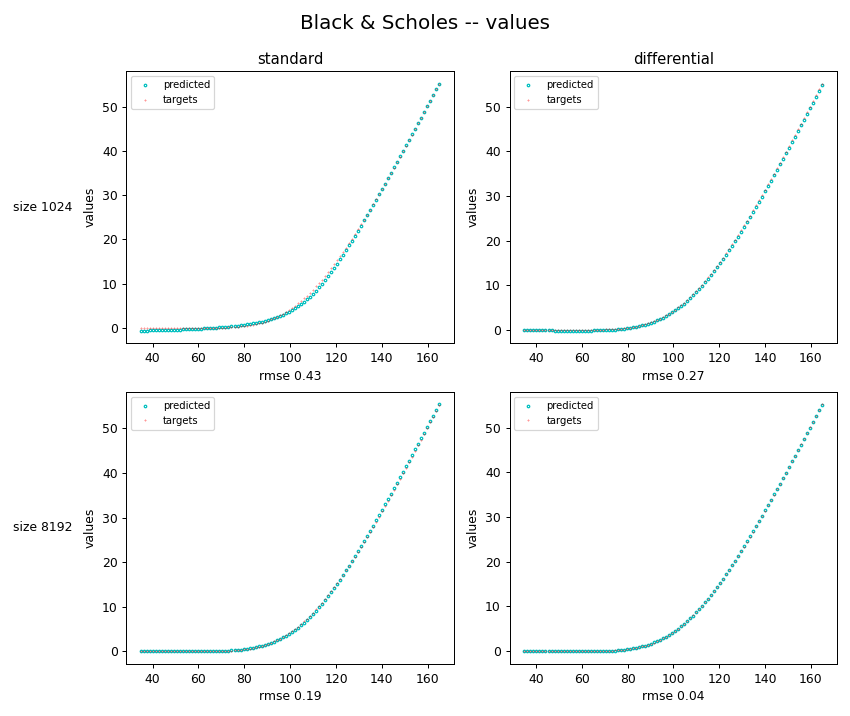

<IPython.core.display.Javascript object>


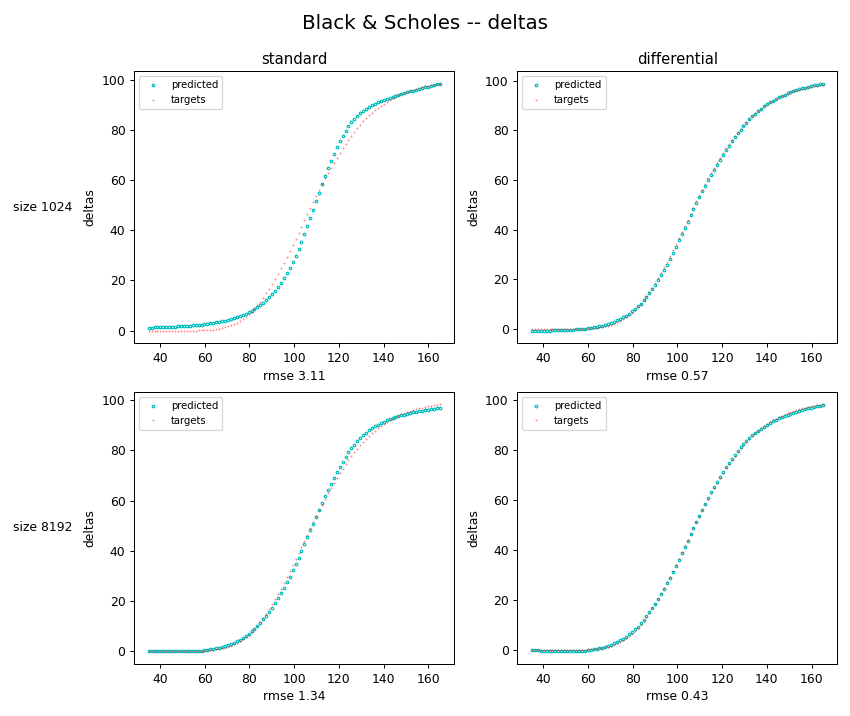

In [12]:
# show predicitions
graph("Black & Scholes", values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Black & Scholes", deltas, xAxis, "", "deltas", dydxTest, sizes, True)

## Gaussian basket options

The recent success of deep learning is largely due to their ability to break the long standing *curse of dimensionality* that breaks classic regression models in high dimension. Contrarily to classic linear models, neural networks don't regress on a fixed set of basis functions. They *learn from data* a relevant regression basis in their hidden layers, embedding a powerful dimension reduction capability in their structure. This is why deep learning succeeded in such high dimensional tasks as computer vision, where the dimension of the inputs is the number of pixels in a picture. Convolutional nets effectively learn the low dimensional features that matter to e.g. image recognition, something a classic regression model couldn't do.

*Differential* machine learning also shines in high dimension, where differential labels help identify relevant features more effectively. In fact, the additional performance from differential training exponentially increases with dimension. This is why twin networks are particularly effective for learning values of complex transactions or trading books as functions of a high dimensional state. 

To illustrate this ability in a simple context, we extend the Black & Scholes example to a basket option written on $n$ correlated stocks. In place of the Black & Scholes model, the stocks are simulated in Bachelier's Gaussian model, where the true price of the basket option is known in closed form, and given by Bachelier's formula applied to the basket at $T_1$. Therefore, we can monitor the performance of our approximators by comparison to the correct, analytic  prices and deltas.

In addition, the example is particularly interesting because *the price is really a non-linear function of the one-dimensional basket*. We expect the machine to learn that from data, and twin networks achieve this a lot better than feedforward networks. The stellar results of the section 3.1 of the article demonstrate the power of differential learning. 

The code below follows the exact same logic as the *BlackScholes* simulator to simulate LSM samples for a basket option in a $n$-dimensional, correlated Bachlier model. The correlations, volatility and basket weights are re-generated randomly on every run, allowing to verify performance in multiple configurations. It is a direct extension of the *BlackScholes* simulator and, as such, such be rather self explanatory.

In [13]:
# helper analytics
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])
#

class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape(-1,1), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        np.random.seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * np.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = np.random.uniform(low=adj_lower, high = adj_upper, size=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    

We can reuse our testing functions without modification, starting with dimension 1, where the basket is a European call, priced in the Bachelier model, very similar to Black & Scholes. Unsurprisingly, the results are identical.

In [14]:
# basket / bachelier dimension
basketDim = 1

# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 8965
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024




size 8192


<IPython.core.display.Javascript object>


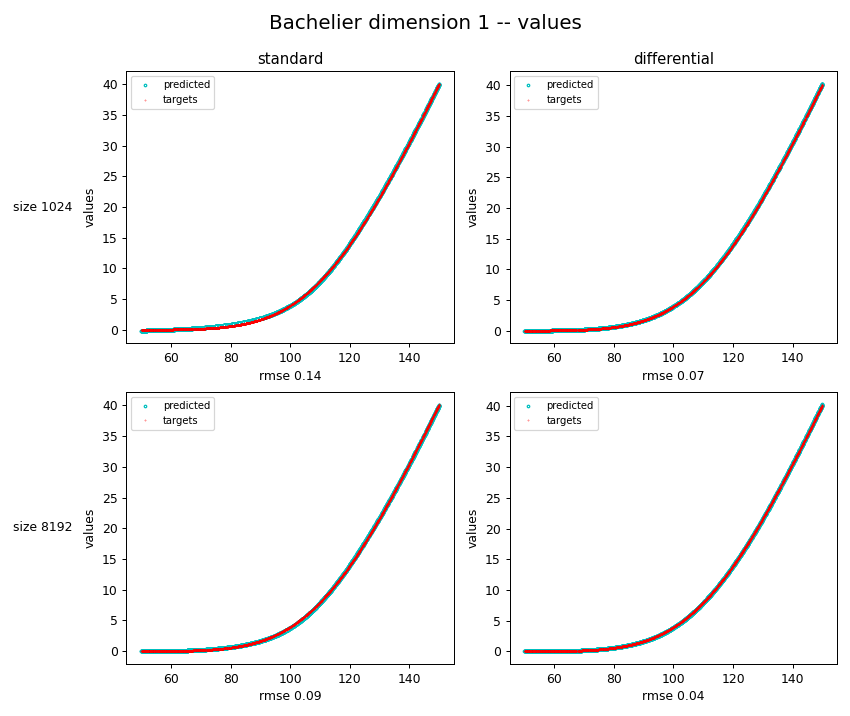

<IPython.core.display.Javascript object>


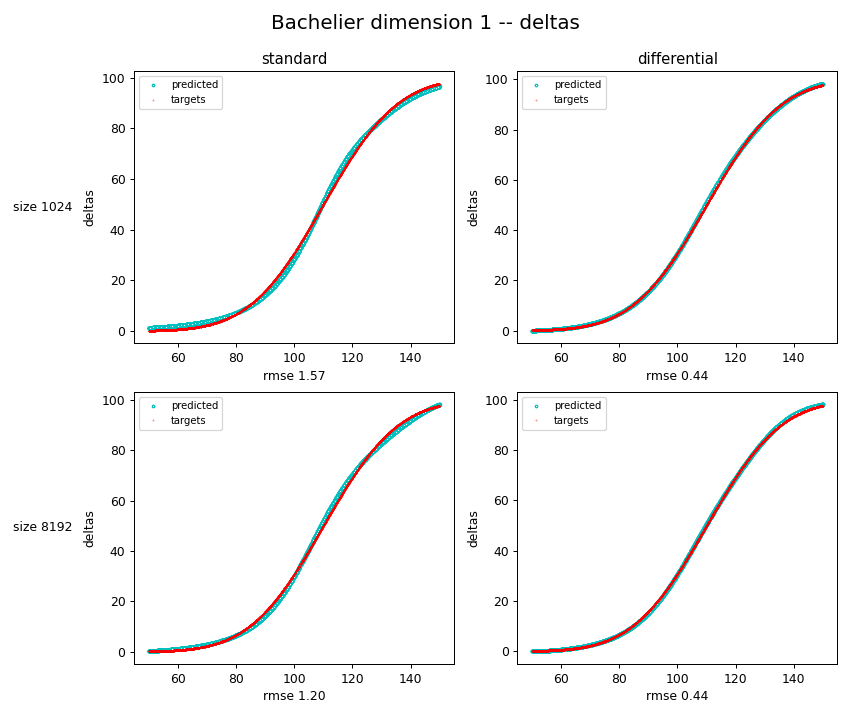

In [15]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

Moving on to the dimension 7 of the article, we display predictions and correct values as a function of the underlying basket at $T_1$, for 4096 independent examples. The thickness of the plot measures the ability to learn from data that the value is a fixed function of the current undelying basket. A thin curve reflects that this property is correctly learned. A thick line means that the approximator predicts different values for different sets of stocks corresponding to the same basket, hence, failing to learn the pricing function correctly.

In [16]:
# basket / bachelier dimension
basketDim = 7

# simulation set sizes to perform
sizes = [4096, 8192, 16384]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 1633
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096




size 8192




size 16384


<IPython.core.display.Javascript object>


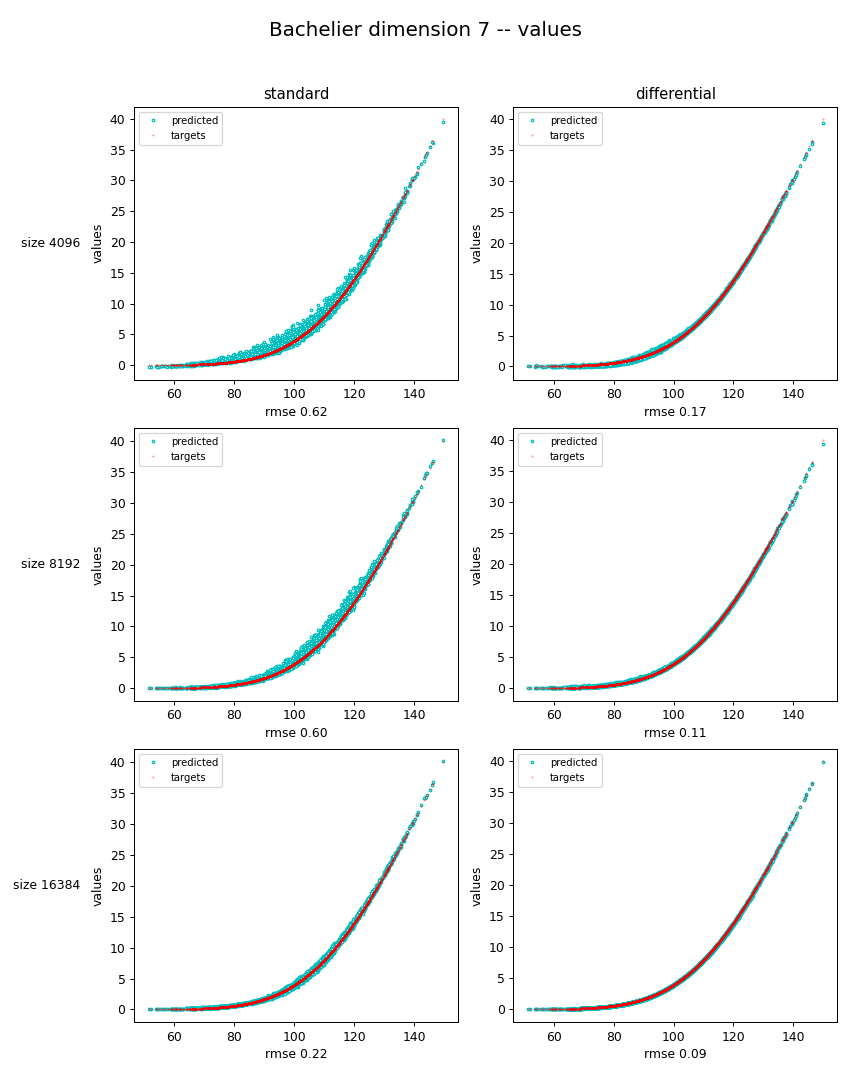

<IPython.core.display.Javascript object>


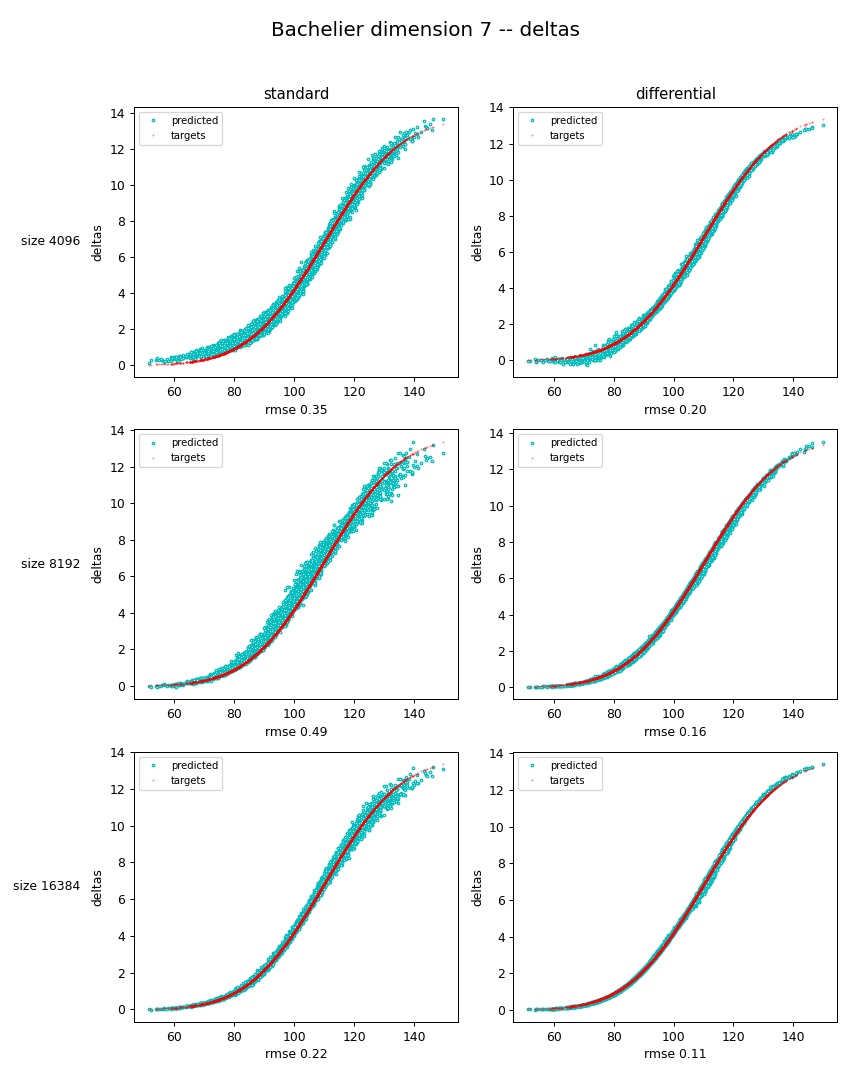

In [17]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

We reproduce the result of the article where both networks converge to a correct approximation, but differential training gets there orders of magnitude faster, and especially outperforms on smaller training sets. This is what makes it so particularly relevant for the risk management of financial Derivatives.

Below, we test dimension 20. Notice that learning time is virtually unaffected by dimension, and that the performance of the twin network is resilient to high dimensionality, where the standard network starts to struggle. 

Our simple implementation correctly works in dimension up to 30 something. The more thorough data preparation discussed in [this appendix](https://github.com/differential-machine-learning/appendices/blob/master/App2-Preprocessing.pdf) in necessary for higher dimensions. 

In [18]:
# basket / bachelier dimension
basketDim = 20

# simulation set sizes to perform
sizes = [4096, 8192, 16384]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 5742
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096




size 8192




size 16384


<IPython.core.display.Javascript object>


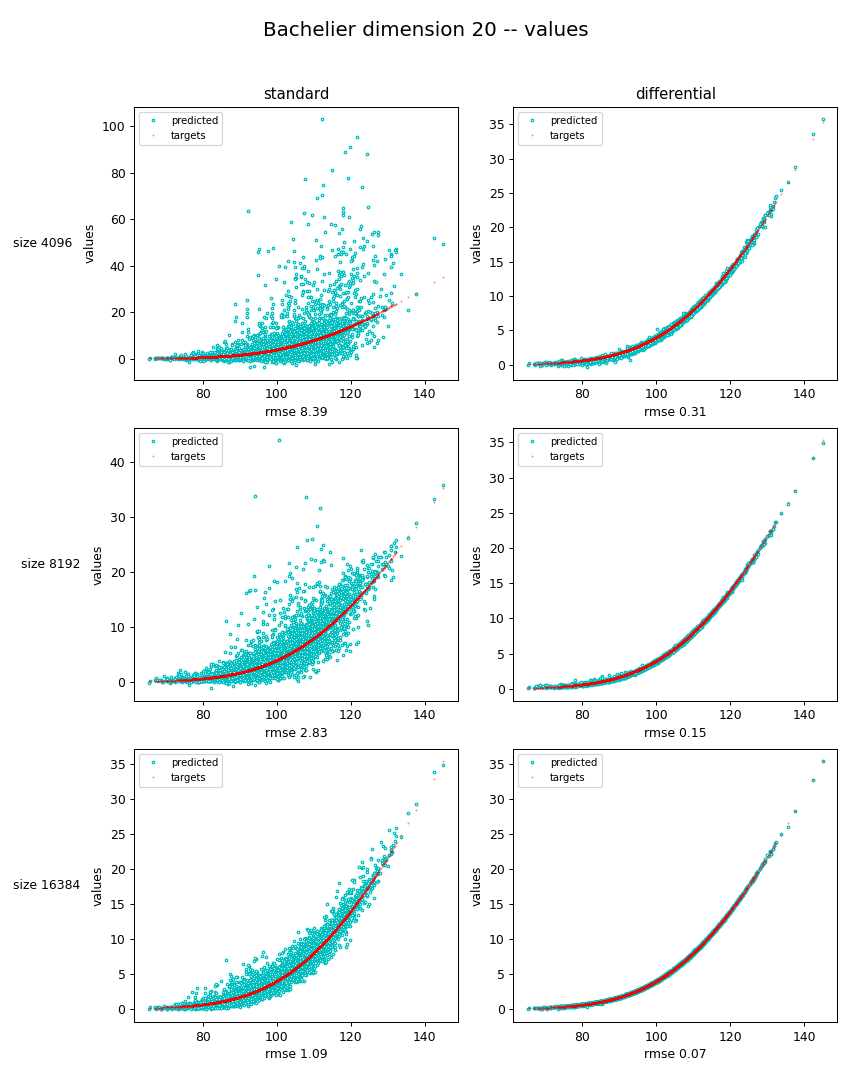

<IPython.core.display.Javascript object>


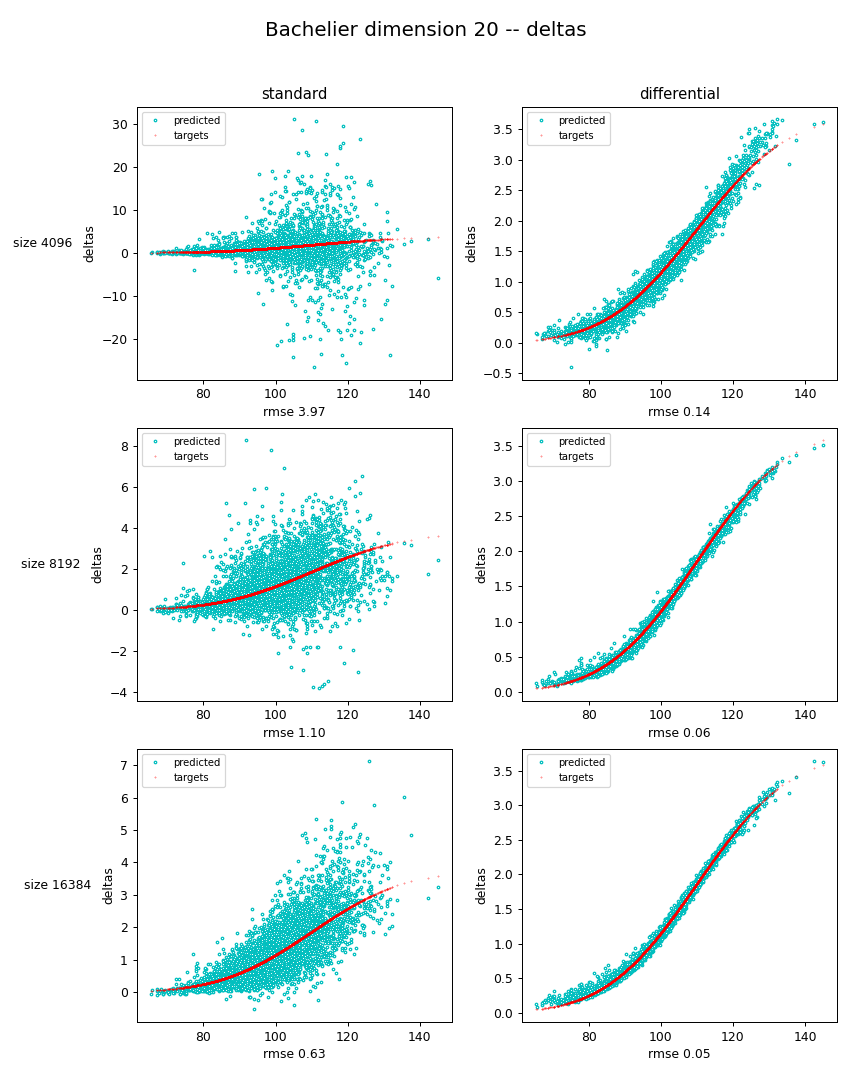

In [19]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

# Conclusion: Automatic Adjoint Differentiation (AAD)
---

We implemented the main ideas of the working paper and verified their unreasonable effectiveness for the approximation of pricing and risk functions in finance. Everything relies on *differential labels*, the gradients of training labels to training inputs, fed to the machine learning model in an augmented dataset. We have seen that training on differentials offers a massive performance improvement, but, of course, the differential labels must be computed first.

In particularly simple textbook contexts, like a European call in Black & Scholes or a basket option in multi-dimensional Bachelier, differential labels are easily computed in explicit form. In low dimension, they could be computed by finite differences. In a general case with an arbitrary schedule of complex cash-flows simulated in an arbitrarily sophisticated model, closed form differentials are not available and finite differences are far too slow. In dimension 100, every training example must be computed 101 times to estimate differentials by finite differences. In addition, differentials approximated by finite differences may not be accurate enough for the purpose of training: we don't want the optimizer chasing imprecise differentials.

Introduced to finance by the ground breaking *Smoking Adjoints* (Giles and Glasserman, Risk 2006), AAD is a game changing technology allowing to compute differentials of arbitrary computations, automatically, with analytic precision, and for a computation cost of around 2 to 5 times one evaluation, depending on implementation, and *independently on the dimension of the gradient*. 

AAD arguably constitutes the most significant progress in computational finance of the past 20 years. It gave us real-time risk reports for complex Derivatives trading books and regulations like XVA, as well as instantaneous calibrations. It made differentials massively available for research and development in finance. Quoting the conclusion of our Wilmott piece *Computation graphs for AAD and Machine Learning parts 1, 2 and 3* (Savine, Wilmott Magazine, 2019-2020):

*New implementations of AAD are pushing the limits of its efficiency, while quantitative analysts are leveraging them in unexpected ways, besides the evident application to risk sensitivities or calibration.*

To a large extent, differential machine learning is another strong application of AAD. It is AAD that gave us the massive number of accurate differentials necessary to implement it, for a very cheap computation cost, and is ultimately responsible for the spectacular performance improvement. The real-world examples in the Risk paper, sections 3.2 and 3.3, were trained on AAD differential labels.

The working paper or the complements do not cover AAD. Readers are referred to the (stellar) founding paper. [This textbook](https://www.amazon.com/Modern-Computational-Finance-Parallel-Simulations-dp-1119539455/dp/1119539455) provides a complete, up to date overview of AAD, its applications in finance, and a complete, professional implementation in modern C++.

The video tutorial below introduces the core ideas in 15 minutes. Click on the picture to play. 

[<img src="https://miro.medium.com/max/1400/1*bHsIA1jy08p71uZcg8HiIQ.png" />](https://towardsdatascience.com/automatic-differentiation-15min-video-tutorial-with-application-in-machine-learning-and-finance-333e18c0ecbb)[Towards Data Science: AAD Explained in 15min](https://towardsdatascience.com/automatic-differentiation-15min-video-tutorial-with-application-in-machine-learning-and-finance-333e18c0ecbb)

